# Predicting Wavebands with a cGAN
One of the most exciting applications of deep learning is image-to-image translation which includes tasks such as image colourisation and super resolution. This task needed a lot of human input and hardcoding several years ago but, with the development of deep learning over recent years, the whole process can be done end-to-end with the power of machine learning. 
This task will be focused on predicting longer waveband data, *2.4-5.0µm*, from the recent CEERS JWST data release 0.5 from short waveband data, *0.5-2.4µm*, using a conditional Generative Adversarial Network (cGAN). The stategy follows closely to that used in [_**Image-to-Image Translation with Conditional Adversarial Networks**_](https://arxiv.org/abs/1611.07004) which may also be known by *pix2pix* where a general solution to many image-to-image translation problems is proposed, one being image colourisation. In this approach, two losses are used, namely an L1 loss, which makes this task a regression task, and an adversarial (GAN) loss, which helps to solve the problem in an unsupervised manner. 

### The World of GANs ###
The architecture used in this problem is a conditional GAN which uses an extra loss function, the L1 loss. It is useful to understand the setup of a GAN.
In a GAN, there is a Generator and a Discriminator network which work together to solve a problem. In this model, the Generator network takes a 1-channel input (the shorter wavebands flattened to 1 channel) and produces a 2-channel output. The Discriminator network takes the two produced channels and decides whether it is real or fake. Naturally, the Discriminator needs to see real outputs - those that are not produced by the Generator, and should learn that they are real. 
The condition on this model is that both the Generator and Discriminator *see* the input.
Let's take a further look into what the cGAN is doing. Consider _**x**_ to be the input to the network, _**z**_ as the input noise for the Generator, and _**y**_ the 2-channel output we expect from the Generator. Let G and D denote the Generator and Discriminator networks, respectively. The loss of the cGAN can be described via:
\
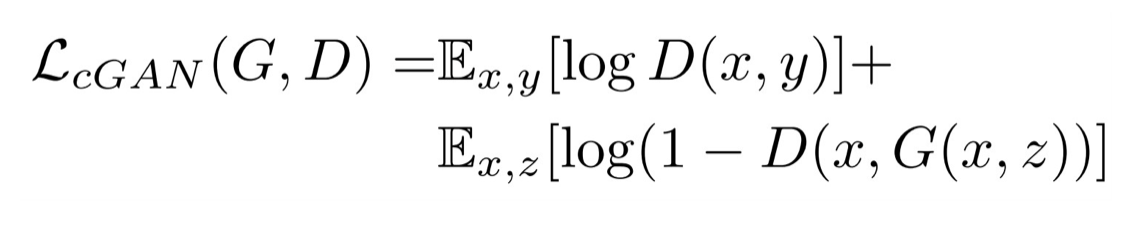\.
\
Note that _**x**_ is the condition that we have introduced and it is seen by both networks. Also note that we are *not* feeding an *n*-dimensional vector of random noise to the Generator, which is common in machine learning networks, since the noise is introduced in the form of dropout layers in the Generator network.

#### Loss Function ####
The goal is optimisation and, more specifically, to minimise the loss. The above loss function helps to produce an output that seems real, however, to further steer the model in the right direction and to introduce some supervision into this task, we combine the above loss with the L1 loss (which can be also known as the mean absolute error):
\
![L1-loss.png](L1-loss.png)\.
\
The model will learn features from the data using the L1 loss alone, but it will be conservative and take an average which will reduce the L1 loss as much as possible (this can be compared to the blurring effect of L1 or L2 loss in a super resolution task). Combining the adversarial loss with the L1 loss gives the overall loss function for the model:
\
![Loss.png](Loss.png)\,
\
where *λ* is the coefficient to balance the contribution of the two losses to the final loss. Note that the discriminator loss does not involve the L1 loss. 

### Implementing the cGAN ###
The cGAN is implemented using Pytorch; a convenient package for machine learning models. This example uses ~ 1900 input data in the form of the galaxy cutouts extracted from the CEERS JWST data release 0.5. You are welcome to train the network on your own data provided it is in the same format. This will be discussed in the relevant section.


In [1]:
# Import useful packages
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
from astropy.io import fits
import warnings

warnings.filterwarnings("ignore", module="matplotlib\..*")

In [2]:
# Path to working directory (use directory where your data is saved)
home = "/Users/ruby/Documents/Python Scripts/Filters/"

Before we create our dataset and dataloaders, both the train and test data needs to be normalised for the model to train. The data is normalised on the interval [0,1] using a function. You may wish to change this using more efficient methods such as MinMaxScaler().

In [3]:
# normalise the values between 0 and 1
def Normalise(data, lower=0, upper=1):
    return ((data - data.min())/ (data.max() - data.min()))

#### Dataset and Dataloaders ####
Here we create the dataset for our model. First, the data must be transformed to the correct size for the model (256x256). The data in each waveband file is read, appended as an input for short wavebands (as a label for long wavebands) and normalised using the above function. Both the inputs and labels are transformed to a tensor of shape [(channel, height, width)] before being resized to 256x256. We then split the dataset into training and testing, using 90% of the data to train and 10% for testing, before creating the dataloaders. 

In [4]:
SIZE = 256
class FilterDataset(Dataset):
    def __init__(self, path):
        ''' path = path to directory containing fits files '''
        self.path = path
        self.transforms_inputs = torch.nn.Sequential(transforms.Resize((SIZE, SIZE)))
                                                     
        self.transforms_labels = torch.nn.Sequential(transforms.Resize((SIZE, SIZE)))
                                                    
        self.f115w_path = path+'F115W/'
        self.f150w_path = path+'F150W/'
        self.f200w_path = path+'F200W/'
        self.f277w_path = path+'F277W/'
        self.f356w_path = path+'F356W/'
        self.f444w_path = path+'F444W/'
        self.l1 = len(os.listdir(self.f115w_path)) - 1 # might want to remove -1
    
    def __len__(self):
        # return total number of fits files for the galaxy cutouts consistent
        # with the 'idx' in the __getitem__ method
        return (self.l1)
    
    def __getitem__(self, idx):
        # get the name of the fits file
        name = str(idx)+'galaxy_cutout.fits'
        # for each input filter, get each fits file, open and extract the 
        # first row (only row which is 'SCI' data) and normalise before
        # formatting into an array
        hdu1 = fits.open(self.f115w_path+name)[0]
        data1 = hdu1.data
        hdu2 = fits.open(self.f150w_path+name)[0]
        data2 = hdu2.data
        data1 += data2
        hdu3 = fits.open(self.f200w_path+name)[0]
        data3 = hdu3.data
        data1 += data3
        data1 = Normalise(data1)

        # now the same for the label filters as 
        hdu4 = fits.open(self.f277w_path+name)[0]
        data4 = hdu4.data
        hdu5 = fits.open(self.f356w_path+name)[0]
        data5 = hdu5.data
        data4 += data5
        hdu6 = fits.open(self.f444w_path+name)[0]
        data6 = hdu6.data
        data4 += data6
        data4 = Normalise(data4)
        
        # the input filters (f115w, f150w, f200w)
        inputs = np.array(data1).astype("float32")
        # reformat the inputs as tensors
        inputs = transforms.ToTensor()(inputs)
        # reshape the tensor to [C, H, W] for the transform to work
        inputs = inputs.permute(0,1,2)
        # transform the input tensor by resizing to (256,256) and changing
        # the number of output channels to 1
        inputs = self.transforms_inputs(inputs)
        # do the same for the labels
        labels = np.array(data4).astype("float32")
        labels = transforms.ToTensor()(labels)
        labels = labels.permute(0,1,2)
        labels = self.transforms_labels(labels)
        # since the labels need to have 2 C channels for the network,
        # repeat the grayscale channel twice 
        labels = labels.repeat(2,1,1)
        
        # return the inputs with corresponding labels in a dictionary
        return {'Inputs': inputs, 'Labels': labels}

In [5]:
dataset = FilterDataset(path=home)
print(dataset)

In [6]:
# split the generated dataset into training and testing 
BATCH_SIZE = 16                                      # set the batch size
VALIDATION_SPLIT = 0.1                              # set the validation split of 10%
SHUFFLE_DATASET = True                              # shuffle the training data only
RANDOM_SEED = 42                                    # randomly shuffle through indexed dataset

# create indices for training and test split
DATASET_SIZE = len(dataset)
# list the dataset with an index for each entry
indices = list(range(DATASET_SIZE))
# define the split for the dataset
split = int(np.floor(DATASET_SIZE * VALIDATION_SPLIT))
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
# split the dataset into training and testing 
train_indices, test_indices = indices[split:], indices[:split]

# create data samplers and dataloaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
# create dataloaders
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
testloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
print(len(trainloader), len(testloader)) 


110 13


In [7]:
data = next(iter(trainloader))
inputs_, labels_ = data['Inputs'], data['Labels']
print(inputs_.shape, labels_.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])


#### Generator Architecture ####
The following code implements a U-Net to be used as the Generator for the cGAN. It produces the U-Net from the middle part, down in the U shape, and adds down-sampling and up-sampling modules to the left and the right of the middle module, respectively, at every iteration until it reaches the input module and output module:\
![U-Net.png](U-Net.png)\
\
The blue boxes show the order in which the related modules are built. The U-Net shown in the following code has more layers than depicted above. In the code, we go 8 layers down, so, starting with a 256x256 input, we will get a 1x1 (256/2⁸) image in the middle of the U-Net which then gets up-sampled to produce a 256x256 image with 2 channels. 

In [8]:
# U-Net module
class UnetBlock(nn.Module):
    ''' U-Net is used as the generator of the GAN.
        Creates the U-Net from the middle part down and adds down-sampling and
        up-sampling modules to the left and right of the middle module.
        8 layers down so start with a 256x256 tensor with 1 channel, down-sample 
        to a 1x1 tensor, then up-sample to a 256x256 tensor with 2 channels. '''
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        ''' ni = number of filters in the inner convolution layer
            nf = number of filters in the outer convolution layer
            input_c = number of input channels (= 1)
            submodule = previously defined submodules
            dropout = not using dropout layers '''
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(in_channels=input_c, out_channels=ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost: # if this module is the outermost module i.e downsampling
            upconv = nn.ConvTranspose2d(in_channels=ni*2, out_channels=nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost: # if this module is the innermost module, i.e upsampling
            upconv = nn.ConvTranspose2d(in_channels=ni, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(in_channels=ni*2, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else: # add skip connections
            return torch.cat([x, self.model(x)], dim=1)

class Unet(nn.Module):
    ''' U-Net based generator.'''
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        ''' input_c = number of input channels (= 1)
            output_c = number of output channels (= 2)
            n_down = number of downsamples: we start with 256x256 and after 
                                            8 layers, we have a 1x1 tensor at the bottleneck.
            num_filters = number of filters in the last convolution layer. '''
        super().__init__()
        unet_block = UnetBlock(num_filters*8, num_filters*8, innermost=True)
        for _ in range(n_down - 5):
            # adds intermediate layers with num_filters * 8 filters
            unet_block = UnetBlock(num_filters*8, num_filters*8, submodule=unet_block, dropout=True)
        out_filters = num_filters*8
        for _ in range(3):
            # gradually reduce the number of filters to num_filters
            unet_block = UnetBlock(out_filters//2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

#### Discriminator Architecture ####
The following code describes the architecture of the Discriminator which implements a model by stacking blocks of Convolution - Batch Normalisation - Leaky ReLU to decide whether the input is real or fake. The first and last blocks do *not* use batch normalisation and the last block has *no* activation function (because the activation function will be embedded in the loss function we will use later).

In [9]:
# Using a Patch-Discriminator
class PatchDiscriminator(nn.Module):
    ''' Patch discriminator stacks blocks of convolution-batchnorm-leakyrelu 
        to decide whether the input tensor is real or fake. 
        Patch discriminator outputs one number for every NxN pixels of the input
        and decides whether each "patch" is real/fake. 
        Patches will be 70 by 70. '''
    def __init__(self, input_c, num_filters=64, n_down=3):
        ''' input_c = number of input channels (= 1)
            num_filters = number of filters in last convolution layer
            n_down = number of layers '''
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        # use if statement to take care of not using a stride of 2 in the last block of the loop
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i+1), s=1 if i == (n_down-1) else 2) for i in range(n_down)]
        # do not use normalisation or activation for the last layer of the model
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # ouput 1 channel prediction
        self.model = nn.Sequential(*model)
    
    # make a separate method for the repetitive layers
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        ''' norm = batch norm layer
        act = apply activation '''
        layers = [nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=k, stride=s, padding=p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x) 

Look at its blocks:

In [10]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

Ans the shape of its output:

In [11]:
discriminator = PatchDiscriminator(3)
input_ = torch.randn(16, 3, 256, 256) # [Batch, Channels, Height, Width]
output = discriminator(input_)
output.shape

torch.Size([16, 1, 30, 30])

Notice that we are using a Patch Discriminator. What is a Patch Discriminator?
\
In a vanilla discriminator, the model outputs one number (a scalar), which represents how much the model thinks the input is real (or fake). In a patch discriminator, the model outputs one number for every patch of ~70x70 pixels of the input and for each of them, decides whether it is real (or fake), separately. Using such a model for this task is reasonable because the local changes that the model needs to make are important. Making a decision on the whole input regarding whether it is real or fake, as in a vanilla discriminator, cannot take care of the subtleties of this task. 
Here, the model's output shape is 30x30 but that does not mean that the patches are of size 30x30. The actual patch size is obtained when we compute the [_**receptive field**_](https://www.researchgate.net/figure/The-PatchGAN-discriminator-where-the-receptive-field-of-the-discriminator-is-N-N-Gz_fig5_336431839) of each of these 900 (30x30=900) output numbers, which will be 70 by 70 in this case. 

#### GAN Loss ####
We need to initiate the adversarial GAN loss for the final model. Below, in the **init** function, we decide what type of loss we will use ("vanilla") and we register some constant tensors as the "real" and "fake" labels, representing a tensor of all 1's or all 0's, respectively. It fills these tensors when we call the module and computes the loss.

In [12]:
# Unique loss function for the GAN 
class GANLoss(nn.Module):
    ''' Calculates the GAN loss of the final model.
        Uses a "vanilla" loss and registers constant tensors for the real
        and fake labels. Returns tensors full of zeros or ones to compute the loss'''
        
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer(name='real_label', tensor=torch.tensor(real_label))
        self.register_buffer(name='fake_label', tensor=torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss() # binary cross entropy loss
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss() # don't use this
        
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds) # expand to the same size as predictions
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

#### Model Initialisation ####
Here, we initialise the weights of the model with a mean, µ=0, and a standard deviation, σ=0.02. We also initialise the entire model by sending to model to the device (I'm using "cuda" but you can choose which device you wish to use) and initialising its weights.

In [13]:
# Initilise the weights of the model here
def Init_Weights(net, init='norm', gain=.02):
    ''' Image-to-image translation paper state that the model is initialised 
        with a mean of 0.0 and std 0.02'''
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                # fills tensor with values drawn from normal distribution N(mean,std^2)
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier': # taken from a paper
            # fills input tensor with avlues sampled from N(0,std^2)
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming': # taken from a paper
                # resulting tensor has values sampled from N(0,std^2)
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(tensor=m.bias.data, val=0.0) # tensor filled with zeros
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(tensor=m.bias.data, val=0.0)
    
    net.apply(init_func)
    print(f"model initialised with {init} initialisation")
    return net

def Init_Model(model, device):
    model = model.to(device)
    model = Init_Weights(model)
    return model

#### The Model ####
The following code is a class that brings all the previous sections together and implements the methods required to train the model.
\
Firstly, in the **init** function, we define the Generator and Discriminator networks using the above classes that we defined and we initialise them using the **Init_Model** function above. We define the two loss functions that we have discussed and the optimisers of both the Generator and Discriminator (we use the [_**Adam**_](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimiser which is similar to applying the Gradient Descent Method). It is also worth noting the learning rate of both the Generator and Discriminator, which have a learning rate of *lr_G=lr_D=0.0002*. A small learning rate, such as this, changes the weights little at a time as opposed to drastically changing the weights.
\
The majority of the computations are done in the **optimise** method of this class. First, and only once per iteration (batch of the training set), we call the module's forward method and store the outputs in the *fake_fits* variable of the class. 
\
The Discriminator is trained first using the **backward_D** method, where we feed the *fake* data produced by the Generator to the Discriminator (we detach them from the Generator's graph to make sure they act as a constant to the Discriminator) and label the data as *fake*. A batch of *real* data from the training set is then fed to the Discriminator and labelled as *real*. The losses for the *fake* and *real* data is calculated and added togther, the average between the two taken, and the backward method called on the final loss. The Generator is then trained. In the **backward_G** method, the Discriminator is fed the *fake* data and we try to fool the Discriminator by assigning *real* labels and calculating the adversarial (GAN) loss. As previously mentioned, the L1 loss is also used to compute the distance between the predicted output and the target output, which is then multipled by the coefficient *λ* (where we have set λ=100) to balance the two losses before adding this loss to the adversarial loss. 
\
The backward method of the loss is finally called. 

In [14]:
# cGAN Model
class GANModel(nn.Module):
    ''' Initialises the model defining the generator and discriminator in the
        __init__ function using the functions given and initialises the loss
        functions '''
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=.5, beta2=.999, lambda_L1=100.): 
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = Init_Model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G.to(self.device)
        
        self.net_D = Init_Model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GAN_loss = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1_loss = nn.L1Loss()
        # initialise optimisers for generator and discriminator using Adam optimiser
        # and parameters stated in the paper 
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1,beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1,beta2))
        # initialise empty lists to append the generator and discriminator losses to
        self.generator_losses, self.discriminator_losses = [], []
        self.discriminator_acc = []
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        # Get the input data and labels
        self.inputs = data['Inputs'].to(self.device)
        self.labels = data['Labels'].to(self.device)
    
    def forward(self):
        # For each batch in the training set, forward method is called and
        # outputs stored in fake_fits variable
        self.fake_fits = self.net_G(self.inputs)
        
    def backward_D(self):
        ''' Discriminator loss takes both target and input images.
            loss_D_real is sigmoid cross-entropy loss of the target tensors and an array
            of ones. 
            loss_D_fake is sigmoid cross-entropy loss of the input tensors and an
            array of zeros.
            Discriminator loss is loss_D = loss_D_real + loss_D_fake. '''
        # Train the discriminator by feeding the fake images produced by the 
        # generator 
        fake_fits = torch.cat([self.inputs, self.fake_fits], dim=1)
        fake_preds = self.net_D(fake_fits.detach()) # detach from generator's graph so they act like constants
        # label the fake images as fake 
        self.loss_D_fake = self.GAN_loss(preds=fake_preds, target_is_real=False)
        self.discriminator_acc += [(torch.mean(fake_preds).item()+ 0.6)/1.2]
        # Now feed a batch of real images from the training set and label them as real
        real_fits = torch.cat([self.inputs, self.labels], dim=1)
        real_preds = self.net_D(real_fits)
        self.loss_D_real = self.GAN_loss(preds=real_preds, target_is_real=True)
        # Add the two losses for fake and real, take the average and call backward()
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * .5
        self.loss_D.backward()
        self.discriminator_losses += [self.loss_D.item()]
    
    def backward_G(self):
        ''' Generator loss is a sigmoid cross-entropy of input tensors and an 
            array of ones. Using the L1 loss, input tensors are structurally
            similar to the target tensors.
            Generator loss is defined as loss_G = loss_G_GAN + loss_G_L1*lambda_L1. '''
        # Train the generator by feeding the discriminator the fake fits data and 
        # fool it by assigning real labels and calculating adversarial loss.
        fake_fits = torch.cat([self.inputs, self.fake_fits], dim=1)
        fake_preds = self.net_D(fake_fits)
        self.loss_G_GAN = self.GAN_loss(preds=fake_preds, target_is_real=True)
        # Use L1 loss so tensors are not averaged over and compute the 
        # difference between the predicted channels and real channels and multiply 
        # by constant lambda 
        self.loss_G_L1 = self.L1_loss(self.fake_fits, self.labels) * self.lambda_L1
        # Add L1 loss to the adversarial loss then call backward()
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
        self.generator_losses += [self.loss_G_GAN.item()]
        
    def optimise(self):
        # Now optimise by the usual method of zeroing the gradients and calling
        # step() on the optimiser
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

#### Helper Functions ####
Below are the functions used to help visualise how the losses of the model are updated and to illustrate the performance of the model. The losses are logged and the results are shown with the help of these useful functions.

In [15]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count
        
def Create_Loss_Meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

# Update losses after each epoch
def Update_Losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
    return loss_meter 

# Plot the losses for both the Generator and Discriminator
def Loss_Plot(model, save=False):
    gen_loss = model.generator_losses
    dis_loss = model.discriminator_losses
    fig = plt.figure(figsize=(12,6))
    plt.plot(gen_loss, label='Generator Loss', color='red')
    plt.plot(dis_loss, label='Discriminator Loss', color='blue', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    if save:
        fig.savefig(f"loss_{time.time()}.png")

# Plots the result from the training set 
def Visualise_Train(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_fits = model.fake_fits.detach()
    real_fits = model.labels
    inputs = model.inputs
    fake_fits_files = ConCat(inputs, fake_fits)
    real_fits_files = ConCat(inputs, real_fits)
    fig = plt.figure(figsize=(16,11))
    for i in range(4):
        ax = plt.subplot(3, 4, i+1)
        # Some cutouts contain a source that is too faint
        # causing the data to be normalised as a zero vector.
        try:
            ax.imshow(inputs[i][0].cpu(), cmap="gray") # change
            ax.set_title(r"SW Channel [$0.6-2.3\mu$m]")
            ax.axis("off")
        except IndexError:
            continue
        ax = plt.subplot(3, 4, i+1+4)
        ax.imshow(fake_fits_files[i])
        ax.set_title("Generated LW")
        ax.axis("off")
        ax = plt.subplot(3, 4, i+1+8)
        ax.imshow(real_fits_files[i])
        ax.set_title(r"Actual LW Channel [$2.4-5.0\mu$m]")
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig("train.png")

# Plots to results from evaluating the model on the test set
def Visualise_Test(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.eval()
    fake_fits = model.fake_fits.detach()
    real_fits = model.labels
    inputs = model.inputs
    fake_fits_files = ConCat(inputs, fake_fits)
    real_fits_files = ConCat(inputs, real_fits)
    fig = plt.figure(figsize=(12,11))
    for i in range(3):
        ax = plt.subplot(3, 3, i+1)
        try:
            ax.imshow(inputs[i][0].cpu(), cmap="gray") # change
            ax.set_title(r"SW Channel [$0.6-2.3\mu$m]")
            ax.axis("off")
        except IndexError:
            continue
        ax = plt.subplot(3, 3, i+1+3)
        ax.imshow(fake_fits_files[i])
        ax.set_title("Generated LW")
        ax.axis("off")
        ax = plt.subplot(3, 3, i+1+6)
        ax.imshow(real_fits_files[i])
        ax.set_title(r"Actual LW Channel [$2.4-5.0\mu$m]")
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig("test2.png")

# Prints the results after each epoch
def Log_Results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

#### Training Function ####
The function below trains the model, feeding data from the training set for the model to learn features from. Here, we set the number of epochs for training. Training with 100 epochs is a recommendation, although, we already see results after 40 epochs. After each epoch, the weights are tuned further to the optimal weight for better model performance. 

In [16]:
def Train_Model(model, trainloader, epochs, display_every=30):
    print("Starting training....")
    start = time.time()
    data = next(iter(trainloader)) # batch for visualising the model output after fixed intervals after training
    for e in range(epochs):
        # function returning a dictionary of objects to log the losses of the complete network
        loss_meter_dict = Create_Loss_Meters() 
        i = 0
        for data in tqdm(trainloader):
            model.setup_input(data)
            model.optimise()
            Update_Losses(model, loss_meter_dict, count=data['Inputs'].size(0)) # updates the log objects
            i += 1
        print(f"\nEpoch {e+1}/{epochs}")
        if i % display_every == 0: 
            print(f"Iteration {i}/{len(trainloader)}")
        total_loss = Log_Results(loss_meter_dict) # function prints out the losses
        print(total_loss)
    Loss_Plot(model, save=True)
    Accuracy_Plot(model, save=False)
    Visualise_Train(model, data)
    endtime = time.time()
    end = endtime - start
    print("Time to train network: {:.2f}s".format(end))

Each epoch takes between 3 to 4 minutes on a powerful GPU. The above code can be altered to test the model on the test set by setting the model to evaluation mode. An example of training the model is shown below:

In [17]:
model = GANModel()
#Train_Model(model, trainloader, epochs=100)

model initialised with norm initialisation
model initialised with norm initialisation


### Results ###
Below shows the model output on the training set after 100 epochs. 
\
![train.png ><](train.png)\
\
\
![test.png ><](test.png)\
\
As we can see, the model has understanding of the features in the data and some colourisation. The accuracy of the discriminator model is ~92%, although, we must see that the model is learning features such as a mostly black background with a central source for each item in the training set. 
Nevertheless, the model is a good baseline model for predicting longer wavebands and can be further implemented to predict sources in unseen data. 